In [1]:
import pandas as pd
import numpy as np
import random as rnd
import re
import pickle

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, balanced_accuracy_score

In [3]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM

from sklearn.metrics import silhouette_score

In [4]:
SEED = 1

In [5]:
features = 'REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT, SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN'
col_names = features.split(',') + ['Class']
# print(col_names)

In [6]:
dataset_dir = '../Datasets/statlog_image_segmentation'
df = pd.read_csv(dataset_dir + '/segment.dat', names=col_names, sep=' ')
df.shape

(2310, 20)

In [7]:
df.head(2)

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN,Class
0,218.0,178.0,9,0.111111,0.0,0.833333,0.547722,1.111109,0.544331,59.629630,52.444443,75.222220,51.222220,-21.555555,46.77778,-25.222221,75.222220,0.318996,-2.040554,6
1,113.0,130.0,9,0.000000,0.0,0.277778,0.250924,0.333333,0.365148,0.888889,0.000000,2.555556,0.111111,-2.666667,5.00000,-2.333333,2.555556,1.000000,-2.123254,3


In [8]:
df.describe()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN,Class
count,2310.000000,2310.000000,2310.0,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2.310000e+03,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000
mean,124.913853,123.417316,9.0,0.014334,0.004714,1.893939,5.709320,2.424723,8.243692e+00,37.051595,32.821308,44.187879,34.145599,-12.690861,21.408850,-8.717989,45.137470,0.426893,-1.362897,4.000000
std,72.956532,57.483851,0.0,0.040154,0.024234,2.698908,44.846457,3.610084,5.881152e+01,38.176410,35.036774,43.527461,36.364773,11.583562,19.571819,11.551628,42.921764,0.228309,1.545335,2.000433
min,1.000000,11.000000,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.589457e-08,0.000000,0.000000,0.000000,0.000000,-49.666668,-12.444445,-33.888890,0.000000,0.000000,-3.044175,1.000000
25%,62.000000,81.000000,9.0,0.000000,0.000000,0.722222,0.355555,0.777780,4.216373e-01,7.296296,7.000000,9.555555,6.027778,-18.555555,4.138889,-16.777779,11.555555,0.284235,-2.188057,2.000000
50%,121.000000,122.000000,9.0,0.000000,0.000000,1.222224,0.833333,1.444444,9.629633e-01,21.592592,19.555555,27.666667,20.333334,-10.888889,19.666666,-10.888889,28.666666,0.374803,-2.051200,4.000000
75%,189.000000,172.000000,9.0,0.000000,0.000000,2.166667,1.806367,2.555556,2.183269e+00,53.212964,47.333332,64.888890,46.500001,-4.222222,35.777780,-3.222222,64.888890,0.540123,-1.562308,6.000000
max,254.000000,251.000000,9.0,0.333333,0.222222,29.222221,991.718400,44.722225,1.386329e+03,143.444440,137.111110,150.888890,142.555560,9.888889,82.000000,24.666666,150.888890,1.000000,2.912480,7.000000


In [9]:
df['Class'].unique()

array([6, 3, 2, 7, 1, 4, 5])

In [10]:
column_names = df.columns
y = df['Class'].copy().values
X = df.drop(['Class'], axis=1).values
# to 0 - N-1
y = y-1

In [11]:
# Normalize feature data
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction Algorithms

* PCA
* ICA
* Randomized Projections
* Any other feature selection algorithm you desire

The image segmentation dataset has 2310 instances from
seven outdoor images: grass (class 1), path (class 2), window
(class 3), cement (class 4), foliage (class 5), sky (class 6),
and brickface (class 7). Each instance corresponds to a 3x3
region with 19 attributes. During dataset processing, we
removed the three redundant attributes (attributes 5, 7, and
9 were reported to be repetitive with attributes 4, 6, and 8
respectively), and normalized the remaining 16 attributes
to the range of [-5, 5]. The 16 attributes contained some
statistical measures of the images, denoted as X 1 , X 2 , ...,

In [102]:
from sklearn.decomposition import PCA, FastICA
from scipy.stats import kurtosis

## PCA

In [33]:
pca = PCA(random_state=SEED)
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

In [34]:
eighen_value = pca.explained_variance_

In [35]:
X_train_transformed = pca.transform(X_train_scaled)

In [36]:
X_train_transformed.shape

(1848, 19)

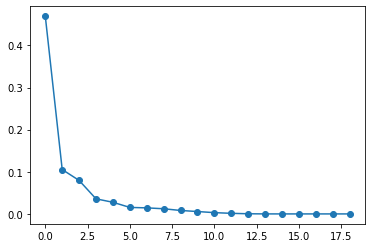

In [37]:
plt.plot(eighen_value,'o-')

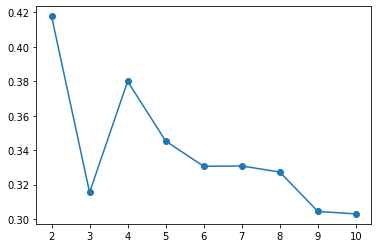

In [21]:
plt.plot(x, km_sil, 'o-')

## ICA

In [101]:
dimensions = [2,4,6,8,10,12,14,16]

kurt = {}
for dim in dimensions:
    ica = FastICA(n_components=dim, random_state=12, max_iter=1000, tol=0.001, fun='exp')
    X_transformed = ica.fit_transform(X_train_scaled)
    X_kurt = np.abs(kurtosis(X_transformed, fisher=True)).mean()
    kurt[dim] = X_kurt
    print(dim)
    
kurt = pd.Series(kurt)

2
4
6


/home/lei/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


8
10


/home/lei/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


12
14
16


In [63]:

np.mean(kurtosis(X_transformed, fisher=True)**2) / 10
## pick k such that the above is maximized

14.018674450481958

In [94]:
kurt

2      0.448068
3      0.777441
4      1.165327
5      1.224550
6      5.800415
8      7.047411
10    12.916328
12    35.004778
dtype: float64

<BarContainer object of 8 artists>

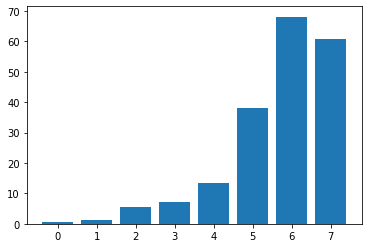

In [100]:
plt.bar(list(range(len(kurt))), kurt)

In [ ]:
# %% Data for 1
ica = FastICA(random_state=self._details.seed)
kurt = {}
for dim in self._dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(self._details.ds.training_x)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[dim] = tmp.abs().mean()

kurt = pd.Series(kurt)

## Randomized Projections

## Any other feature selection algorithm you desire

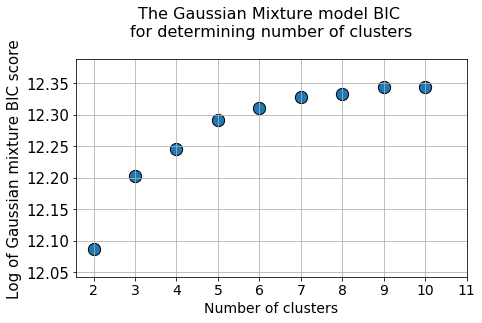

In [36]:
plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,11)],y=[np.log(-x) for x in gmm_bic],s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

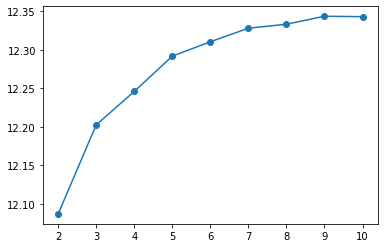

In [34]:
plt.plot(x, [np.log(-x) for x in gmm_bic], 'o-')

In [44]:
[(x[0], abs(x[1])) for x in zip(gm_bic, gmm_bic)]

[(177505.57943638397, 177505.57943640347),
 (207800.61128318627, 199281.65751093192),
 (208075.66093255524, 208139.47144525938),
 (222755.25788145026, 217900.67374122082),
 (223264.34396173098, 222014.31803869223),
 (228611.76833059476, 225965.50976010427),
 (227213.077857716, 227134.68312683314),
 (230941.53570822751, 229505.92230669153),
 (226956.41454585793, 229376.26466122185)]

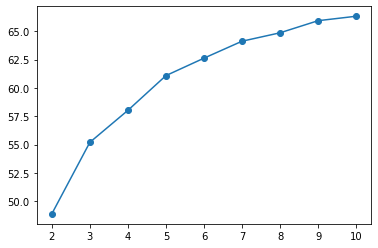

In [23]:
plt.plot(x, gmm_score, 'o-')

In [114]:
sse,iner = calculate_WSS(X_train_scaled, 15)

In [115]:
sse[0], iner[0]

(1437.041122785567, 1437.0411227855932)

In [88]:
Error = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k).fit(X_train_scaled)
    kmeans.fit(X_train_scaled)
    Error.append(kmeans.inertia_)


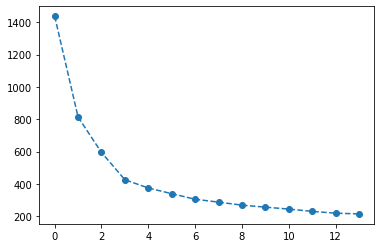

In [89]:
plt.plot(Error, 'o--')

In [70]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k).fit(X_train_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(X_train_scaled, labels, metric = 'euclidean'))

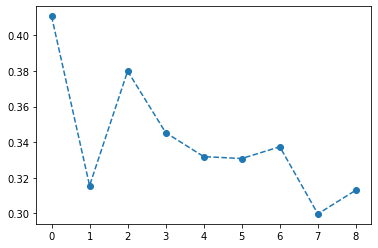

In [71]:
plt.plot(sil, 'o--')

In [67]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score

In [73]:
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
X_scaled = X_train_scaled

for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
#     v_measure = v_measure_score(y_train,preds)
#     vmeasure_score.append(v_measure)
#     print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
#     print("-"*100)

Score for number of cluster(s) 2: -814.8531587558467
Silhouette score for number of cluster(s) 2: 0.4537922528740315
Davies Bouldin score for number of cluster(s) 2: 0.7977661760054997
Score for number of cluster(s) 3: -594.6796308649199
Silhouette score for number of cluster(s) 3: 0.31553457799064183
Davies Bouldin score for number of cluster(s) 3: 1.2070812465017908
Score for number of cluster(s) 4: -425.86547734119654
Silhouette score for number of cluster(s) 4: 0.3799244128195789
Davies Bouldin score for number of cluster(s) 4: 1.0299582813907602
Score for number of cluster(s) 5: -374.9819913820084
Silhouette score for number of cluster(s) 5: 0.3453592110241834
Davies Bouldin score for number of cluster(s) 5: 1.1520036141779533
Score for number of cluster(s) 6: -339.4464562328417
Silhouette score for number of cluster(s) 6: 0.33187862706172055
Davies Bouldin score for number of cluster(s) 6: 1.1365337144553431
Score for number of cluster(s) 7: -305.37941264293124
Silhouette score f

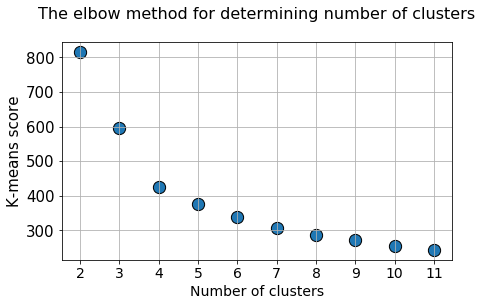

In [74]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

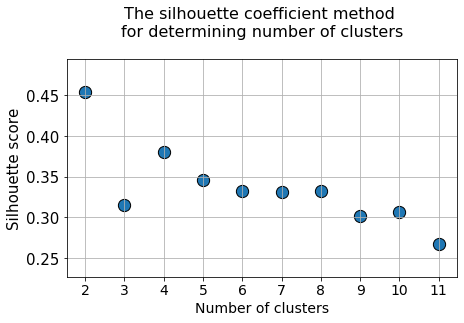

In [76]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

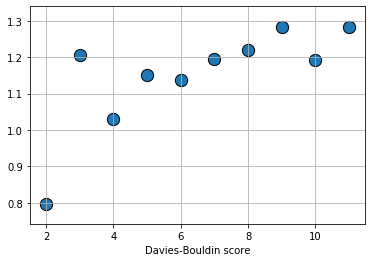

In [77]:

plt.scatter(x=[i for i in range(2,12)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

In [78]:
from sklearn.mixture import GaussianMixture

In [25]:
gm_bic= []
gm_score=[]
for i in range(2,12):
    gm = GMM(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(X_train_scaled)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(X_train_scaled)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(X_train_scaled)))
    print("-"*100)
    gm_bic.append(-gm.bic(X_train_scaled))
    gm_score.append(gm.score(X_train_scaled))

BIC for number of cluster(s) 2: -177505.57943638397
Log-likelihood score for number of cluster(s) 2: 48.87912296078367
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: -207800.61128318627
Log-likelihood score for number of cluster(s) 3: 57.50320907814423
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: -208075.66093255524
Log-likelihood score for number of cluster(s) 4: 58.00500563992219
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: -222755.25788145026
Log-likelihood score for number of cluster(s) 5: 62.40413642776238
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: -223264.34396173098
Log-likelihood score for number of cluster(s) 6: 62.96925453470044
-

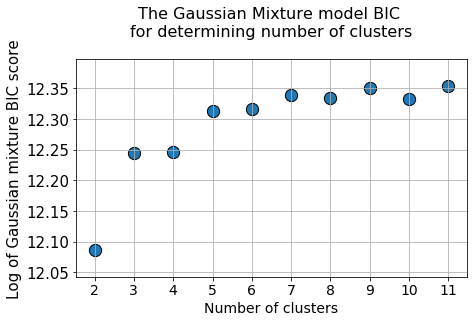

In [26]:

plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

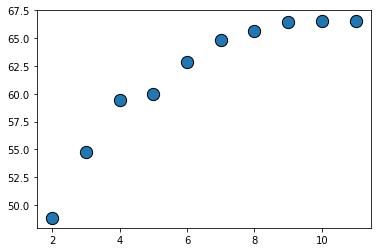

In [81]:
plt.scatter(x=[i for i in range(2,12)],y=gm_score,s=150,edgecolor='k')
plt.show()